Team Name: DataVortex_005_020_044_045

Name 1: Abhishek Bhat - PES1UG22AM005

Name 2: Anagha S Bharadwaj - PES1UG22AM020

Name 3: C Hemachandra - PES1UG22AM044

Name 4: Chaitra V - PES1UG22AM045

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
CIFAR-10 Similar Indices: [42959 15217 29654]
MNIST Similar Indices: [17576  1196 14274]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


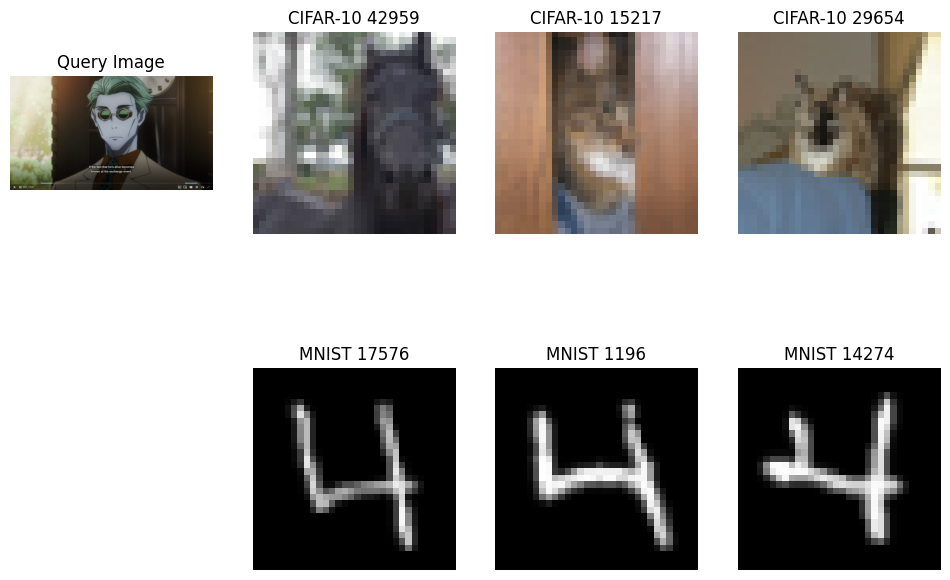

In [ ]:
# Install necessary packages
!pip install pycryptodome faiss-gpu tensorflow opencv-python-headless matplotlib
!pip install cryptography


import numpy as np
import pandas as pd
from Crypto.PublicKey import ECC
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Random import get_random_bytes
import base64
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import cv2
import faiss  # Import FAISS for efficient similarity search
import re

# Load CIFAR-10 dataset and preprocess
def load_cifar10_data():
    (x_train, y_train), (_, _) = cifar10.load_data()  # Only use training data
    x_train = x_train.astype('float32') / 255.0  # Normalize pixel values
    return x_train, y_train

# Preprocess MNIST images for VGG16
def preprocess_mnist_image(image):
    image_resized = cv2.resize(image, (32, 32))  # Resize to VGG16 input size
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    return image_rgb.astype('float32') / 255.0  # Normalize to [0, 1]

# Load MNIST dataset and preprocess
def load_mnist_data():
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = np.array([preprocess_mnist_image(img) for img in x_train])  # Preprocess each image
    return x_train, y_train

# Load a static image instead of capturing from webcam
def load_static_image(path="/content/Screenshot(156).png"):
    image = cv2.imread(path)
    if image is None:
        print("Error: Could not load image from path.")
        return None
    return image

# Preprocess static image for VGG16 model
def preprocess_image(image):
    image_resized = cv2.resize(image, (32, 32))  # Resize to VGG16 dimensions
    image_normalized = image_resized.astype('float32') / 255.0  # Normalize
    image_reshaped = np.expand_dims(image_normalized, axis=0)  # Add batch dimension
    return image_reshaped

# Extract features from dataset using VGG16
def extract_features(data):
    model = VGG16(include_top=False, input_shape=(32, 32, 3), pooling='avg')
    features = model.predict(data)
    return features

# Retrieve similar images from dataset using FAISS
def retrieve_similar_images(dataset, query_image, num_retrievals=3):
    index = faiss.IndexFlatL2(dataset.shape[1])  # L2 distance
    index.add(dataset.astype('float32'))  # Add dataset to the index
    D, I = index.search(query_image.astype('float32'), num_retrievals)  # D: distances, I: indices
    return I[0]





from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

# ECC encryption
def encrypt_ecc(plain_text, public_key):
    # Generate a shared key using ECDH with the public key
    shared_key = private_key.exchange(ec.ECDH(), public_key)
    salt = os.urandom(16)
    kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=32, salt=salt, iterations=100000, backend=default_backend())
    aes_key = kdf.derive(shared_key)

    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(aes_key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    encrypted_text = encryptor.update(plain_text) + encryptor.finalize()

    return salt + iv + encrypted_text

# ECC decryption
def decrypt_ecc(cipher_text, private_key):
    salt = cipher_text[:16]
    iv = cipher_text[16:32]
    encrypted_text = cipher_text[32:]

    # Use ECDH to generate the shared key with the private key
    shared_key = private_key.exchange(ec.ECDH(), public_key)
    kdf = PBKDF2HMAC(algorithm=hashes.SHA256(), length=32, salt=salt, iterations=100000, backend=default_backend())
    aes_key = kdf.derive(shared_key)

    cipher = Cipher(algorithms.AES(aes_key), modes.CFB(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted_text = decryptor.update(encrypted_text) + decryptor.finalize()

    return decrypted_text







# Federated learning: Local model training with adjusted epochs
def train_local_model(client_data, client_labels, epochs=3):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(client_data, client_labels, epochs=epochs, verbose=0)
    return model

# Federated Averaging (FedAvg) for model weights aggregation
def federated_averaging(models):
    weights = [model.get_weights() for model in models]
    avg_weights = [np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))]
    return avg_weights

def main():
    # Load datasets
    cifar_data, cifar_labels = load_cifar10_data()
    mnist_data, mnist_labels = load_mnist_data()

    # Load static image
    query_image = load_static_image()
    if query_image is None:
        return

    query_image_processed = preprocess_image(query_image)

    # Feature extraction
    cifar_features = extract_features(cifar_data)
    mnist_features = extract_features(mnist_data)
    query_image_features = extract_features(query_image_processed)

    # Retrieve similar images
    cifar_similar_indices = retrieve_similar_images(cifar_features, query_image_features)
    mnist_similar_indices = retrieve_similar_images(mnist_features, query_image_features)

    print("CIFAR-10 Similar Indices:", cifar_similar_indices)
    print("MNIST Similar Indices:", mnist_similar_indices)

    # ECC key generation
    key = ECC.generate(curve='P-256')
    pub_key = key.public_key()
    priv_key = key

    # Encrypting indices and features using ECC
    encrypted_query_image_features = encrypt_ecc(query_image_features.tobytes(), public_key)
    encrypted_cifar_similar_indices = encrypt_ecc(str(cifar_similar_indices).encode(), public_key)
    encrypted_mnist_similar_indices = encrypt_ecc(str(mnist_similar_indices).encode(), public_key)


    # Decrypting ECC-encrypted indices
    decrypted_cifar_similar_indices = list(map(int, re.findall(r'\d+', decrypt_ecc(encrypted_cifar_similar_indices, private_key).decode())))
    decrypted_mnist_similar_indices = list(map(int, re.findall(r'\d+', decrypt_ecc(encrypted_mnist_similar_indices, private_key).decode())))


    # Train local models and aggregate with FedAvg
    cifar_local_model = train_local_model(cifar_data, cifar_labels, epochs=2)
    mnist_local_model = train_local_model(mnist_data, mnist_labels, epochs=2)
    global_weights = federated_averaging([cifar_local_model, mnist_local_model])

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 4, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')

    for i, idx in enumerate(cifar_similar_indices):
        plt.subplot(2, 4, i + 2)
        plt.imshow(cifar_data[idx])
        plt.title(f"CIFAR-10 {idx}")
        plt.axis('off')

    for i, idx in enumerate(mnist_similar_indices):
        plt.subplot(2, 4, i + 6)
        plt.imshow(mnist_data[idx].reshape(32, 32, 3))  # Reshape if needed
        plt.title(f"MNIST {idx}")
        plt.axis('off')

    plt.show()

if __name__ == "__main__":
    main()
